In [4]:
suppressMessages(library("ImpulseDE2"))
suppressMessages(library(DESeq2))
suppressMessages(library(ggplot2))
suppressMessages(library(ggrepel))
suppressMessages(library(tidyverse))
suppressMessages(library(ImpulseDE2))
suppressMessages(library(reshape2))
suppressMessages(library(RColorBrewer))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(data.table))
suppressMessages(library(ggpubr))
suppressMessages(library(EnvStats))
suppressMessages(library(gsheet))

In [5]:
#this code is used for the analysis of figure 3 

In [853]:
rm(list=ls())

In [854]:
#loading plasma 
urine_cto=fread("/local/workdir/omm35/aki_cfRNA_analysis/scripts/AKI_urine_CTO_fractions_using_1000_all_genes_marker_genes_with_healthy_samples.csv")
urine_cto$biofluid="urine-cfRNA"
##loading plasma samples
plasma_cto=fread("/local/workdir/omm35/aki_cfRNA_analysis/scripts/AKI_plasma_CTO_fractions_using_1000_all_genes_marker_genes_with_healthy_samples.csv")
plasma_cto$biofluid="plasma-cfRNA"
plasma_cto = plasma_cto %>% filter(!(grepl("B",plasma_cto$sample_id)))

In [855]:
proven_metadata = gsheet2tbl("https://docs.google.com/spreadsheets/d/1qxg1FWcze3dW4tuww8kXCnDwxEUP9P2gmi3jOKv7hRY/edit?usp=sharing")
proven_metadata = proven_metadata %>% select(urine_tube_id,plasma_tube_id,study_id,paired,causeAKI_verified,timepoint)

sample_key = fread("/workdir/omm35/urine_plasma_cfRNA_comparison/metadata_key/aki_metadata.csv")
sample_key =  sample_key %>% select(urine_tube_id,urine_sample_id,timepoint,plasma_sample_id, study_id)

sample_key = sample_key  %>% left_join(proven_metadata,by=c("urine_tube_id","study_id","timepoint"))

In [856]:
plasma_key = sample_key %>% select(-urine_tube_id,-urine_sample_id)
urine_key = sample_key %>% select(-plasma_tube_id,-plasma_sample_id)

In [858]:
plasma_key$plasma_sample_id=paste0(plasma_key$plasma_sample_id,".trimmed")

plasma_cto= plasma_cto %>% left_join(plasma_key,by=c("sample_id"="plasma_sample_id"))

urine_cto= urine_cto %>% left_join(urine_key,by=c("sample_id"="urine_sample_id"))

plasma_cto = plasma_cto%>% select(-plasma_tube_id,-timepoint.y)
urine_cto = urine_cto %>% select(-urine_tube_id,-timepoint.y)

In [861]:
unique(urine_cto$cell_type)

kidney_glomerulus=c("parietal_epithelial_cell")
interstitium=c("pericyte_cell")
proximal_tubule=c("epithelial_cell_of_proximal_tubule")
loop_of_henle=c("kidney_loop_of_Henle_thick_ascending_limb_epithelial_cell",
               "kidney_loop_of_Henle_thin_ascending_limb_epithelial_cell",
               "kidney_loop_of_Henle_thin_descending_limb_epithelial_cell")
distal_convolution=c("kidney_distal_convoluted_tubule_epithelial_cell")
connecting_tube=c("kidney_connecting_tubule_epithelial_cell")
collecting_duct=c(
    "kidney_collecting_duct_intercalated_cell",
                  "kidney_collecting_duct_principal_cell"
                  )
prostate_epithelium=c("basal_cell_of_prostate_epithelium",
                      "club_cell_of_prostate_epithelium_hillock_cell_of_prostate_epithelium_hillock.club_cell_of_prostate_epithelium",
                      "luminal_cell_of_prostate_epithelium")



kidney=c(kidney_glomerulus,interstitium,loop_of_henle,distal_convolution,connecting_tube,collecting_duct,proximal_tubule)

cells_of_interest  = c(loop_of_henle,connecting_tube,proximal_tubule,distal_convolution,collecting_duct)

[1] "B_cell"                                                                                                       
 [2] "T_cell"                                                                                                       
 [3] "adventitial_cell"                                                                                             
 [4] "basal_cell_of_prostate_epithelium"                                                                            
 [5] "basophil"                                                                                                     
 [6] "bladder_urothelial_cell"                                                                                      
 [7] "club_cell_of_prostate_epithelium_hillock_cell_of_prostate_epithelium_hillock.club_cell_of_prostate_epithelium"
 [8] "conventional_dendritic_cell"                                                                                  
 [9] "cytotoxic_T_cell"                                                                                             
[10] "duct_epithelial_cell"                                                                                         
[11] "endothelial_cell"                                                                                             
[12] "epithelial_cell_of_proximal_tubule"                                                                           
[13] "erythrocyte_erythroid_progenitor"                                                                             
[14] "fibroblast_mesenchymal_stem_cell"                                                                             
[15] "hematopoietic_stem_cell"                                                                                      
[16] "innate_lymphoid_cell"                                                                                         
[17] "kidney_collecting_duct_intercalated_cell"                                                                     
[18] "kidney_collecting_duct_principal_cell"                                                                        
[19] "kidney_connecting_tubule_epithelial_cell"                                                                     
[20] "kidney_distal_convoluted_tubule_epithelial_cell"                                                              
[21] "kidney_interstitial_alternatively_activated_macrophage"                                                       
[22] "kidney_interstitial_cell"                                                                                     
[23] "kidney_loop_of_Henle_thick_ascending_limb_epithelial_cell"                                                    
[24] "kidney_loop_of_Henle_thin_ascending_limb_epithelial_cell"                                                     
[25] "kidney_loop_of_Henle_thin_descending_limb_epithelial_cell"                                                    
[26] "luminal_cell_of_prostate_epithelium"                                                                          
[27] "mast_cell"                                                                                                    
[28] "mature_NK_T_cell"                                                                                             
[29] "mesothelial_cell"                                                                                             
[30] "microglial_cell"                                                                                              
[31] "monocyte"                                                                                                     
[32] "mononuclear_phagocyte"                                                                                        
[33] "mucus_secreting_cell_secretory_cell"                                                                          
[34] "myeloid_progenitor"                                                                                           
[35] "natural_killer_ce

In [862]:
#### 
df = rbind(urine_cto,plasma_cto,fill=TRUE)
df$biofluid = factor(df$biofluid,levels =c("plasma-cfRNA","urine-cfRNA"))
colnames(df)[1]="timepoint"

In [864]:
unique(df$causeAKI_verified)
df[is.na(df$causeAKI_verified),]$causeAKI_verified<-"Healthy"
unique(df$causeAKI_verified)
df = df %>% mutate(condition = case_when(
  timepoint=="T0"~"Healthy",
  TRUE~"AKI"
)) 
#'Healthy''ICPi-AIN''obstruction''Prerenal, ICPi-AIN''ATN''obstruction, UTI''chronic changes''obstruction, ATN'
df = df %>% mutate(causes = case_when(
  causeAKI_verified=="Healthy"~"Healthy",
  causeAKI_verified=="ICPi-AIN" | causeAKI_verified=="Prerenal, ICPi-AIN" ~"AIN" ,
  causeAKI_verified=="ATN" | causeAKI_verified=="obstruction, ATN" ~"ATN", 
  TRUE~"other"
)) 

df = df %>% mutate(causes2 = case_when(
  causeAKI_verified=="Healthy"~"Healthy",
  causeAKI_verified=="ICPi-AIN" | causeAKI_verified=="Prerenal, ICPi-AIN" ~"AIN" ,
  TRUE~"other"
)) 

[1] NA                   "ICPi-AIN"           "obstruction"       
[4] "Prerenal, ICPi-AIN" "ATN"                "obstruction, UTI"  
[7] "chronic changes"    "obstruction, ATN"

[1] "Healthy"            "ICPi-AIN"           "obstruction"       
[4] "Prerenal, ICPi-AIN" "ATN"                "obstruction, UTI"  
[7] "chronic changes"    "obstruction, ATN"

In [6]:
#unique(df$causes)

In [7]:
graph = df %>% filter(causes=="AIN" |  causes=="Healthy") %>%  filter(cell_type %in% cells_of_interest) %>% group_by(biofluid,timepoint,sample_id) %>% summarise(fraction=sum(fraction)) %>%  ggplot(.,aes(timepoint,log10(fraction), fill=timepoint)) + 
geom_boxplot(size=0.5, outlier.shape = NA)+ geom_point(position = position_jitterdodge( jitter.width = 0.2,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.2)+theme_classic()+stat_n_text()+
scale_fill_manual(values=c("orange","#B2182B", "#2166AC"))+scale_y_continuous(breaks = c(-5,-4,-3,-2,-1,0,1))+
 theme(
 plot.title=element_text(size=12),
 axis.title=element_text(size=8, color="black"),
 axis.text.y =element_text(size=6,color="black"),
 axis.text.x =element_text(size=6,color="black"),
 title=element_text(size=8, color="black"),
 strip.text=element_text(size=10),
 legend.position="none",
 #strip.text.y = element_blank()
 ) + stat_compare_means(comparisons = list(c("T0", "TP1"), c("TP2", "TP1"), c("T0", "TP2")),
                        method = "wilcox.test",p.adjust="bonferroni",
                                              size=3)+facet_grid(.~biofluid)+ ggtitle("Tubule cells in patients with AIN")

graph = df %>% filter(causes2=="other" |  causes2=="Healthy") %>%  filter(cell_type %in% cells_of_interest) %>% group_by(biofluid,timepoint,sample_id) %>% summarise(fraction=sum(fraction)) %>%  ggplot(.,aes(timepoint,log10(fraction), fill=timepoint)) + 
geom_boxplot(size=0.5, outlier.shape = NA)+ geom_point(position = position_jitterdodge( jitter.width = 0.2,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.2)+theme_classic()+stat_n_text()+
scale_fill_manual(values=c("orange","#B2182B", "#2166AC"))+scale_y_continuous(breaks = c(-5,-4,-3,-2,-1,0,1))+
 theme(
 plot.title=element_text(size=12),
 axis.title=element_text(size=8, color="black"),
 axis.text.y =element_text(size=6,color="black"),
 axis.text.x =element_text(size=6,color="black"),
 title=element_text(size=8, color="black"),
 strip.text=element_text(size=10),
 legend.position="none",
 #strip.text.y = element_blank()
 ) + stat_compare_means(comparisons = list(c("T0", "TP1"), c("TP2", "TP1"), c("T0", "TP2")),
                        method = "wilcox.test",p.adjust="bonferroni",
                                              size=3)+facet_grid(.~biofluid)+ ggtitle("Tubule cells in patients with Other Causes")


graph = df %>%  filter(cell_type %in% cells_of_interest) %>% group_by(biofluid,timepoint,causes2,sample_id) %>% 
summarise(fraction=sum(fraction)) %>%  ggplot(.,aes(timepoint,log10(fraction), fill=causes2)) + 
geom_boxplot(size=0.5, outlier.shape = NA, width=0.8)+ geom_point(position = position_jitterdodge( jitter.width = 0.2,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.2)+theme_classic()+stat_n_text()+scale_y_continuous(breaks = c(-5,-4,-3,-2,-1,0,1))+
 theme(
 plot.title=element_text(size=12),
 axis.title=element_text(size=8, color="black"),
 axis.text.y =element_text(size=6,color="black"),
 axis.text.x =element_text(size=6,color="black"),
 title=element_text(size=8, color="black"),
 strip.text=element_text(size=10),
 legend.position="none",
 #strip.text.y = element_blank()
 ) + stat_compare_means(comparisons = list(c("T0", "TP1"), c("TP2", "TP1"), c("T0", "TP2")),
                        method = "wilcox.test",p.adjust="bonferroni",
                                              size=3)+facet_grid(.~biofluid)+ ggtitle("Tubule cells in patients with AIN")


`summarise()` has grouped output by 'biofluid', 'condition', 'timepoint'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'biofluid', 'condition', 'timepoint'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'biofluid', 'condition'. You can override using the `.groups` argument.


biofluid,condition,cell_type,mean,sdev
<fct>,<fct>,<chr>,<dbl>,<dbl>
plasma-cfRNA,Healthy,Bowman_cells,9.866512e-05,8.232597e-05
plasma-cfRNA,AKI,Bowman_cells,2.061611e-04,1.324770e-04
urine-cfRNA,Healthy,Bowman_cells,1.705288e-04,1.144074e-04
urine-cfRNA,AKI,Bowman_cells,5.019519e-04,1.471226e-03


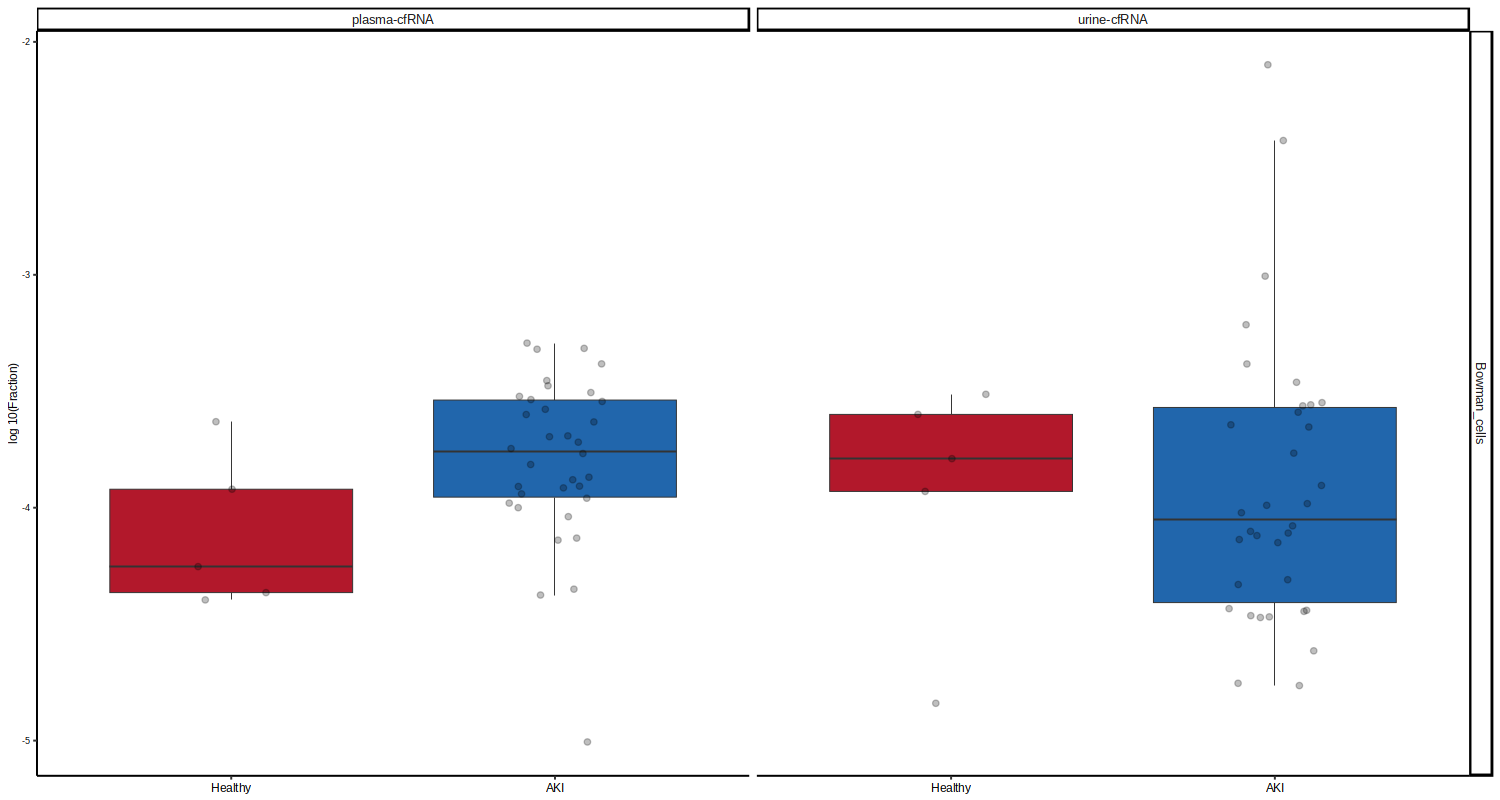

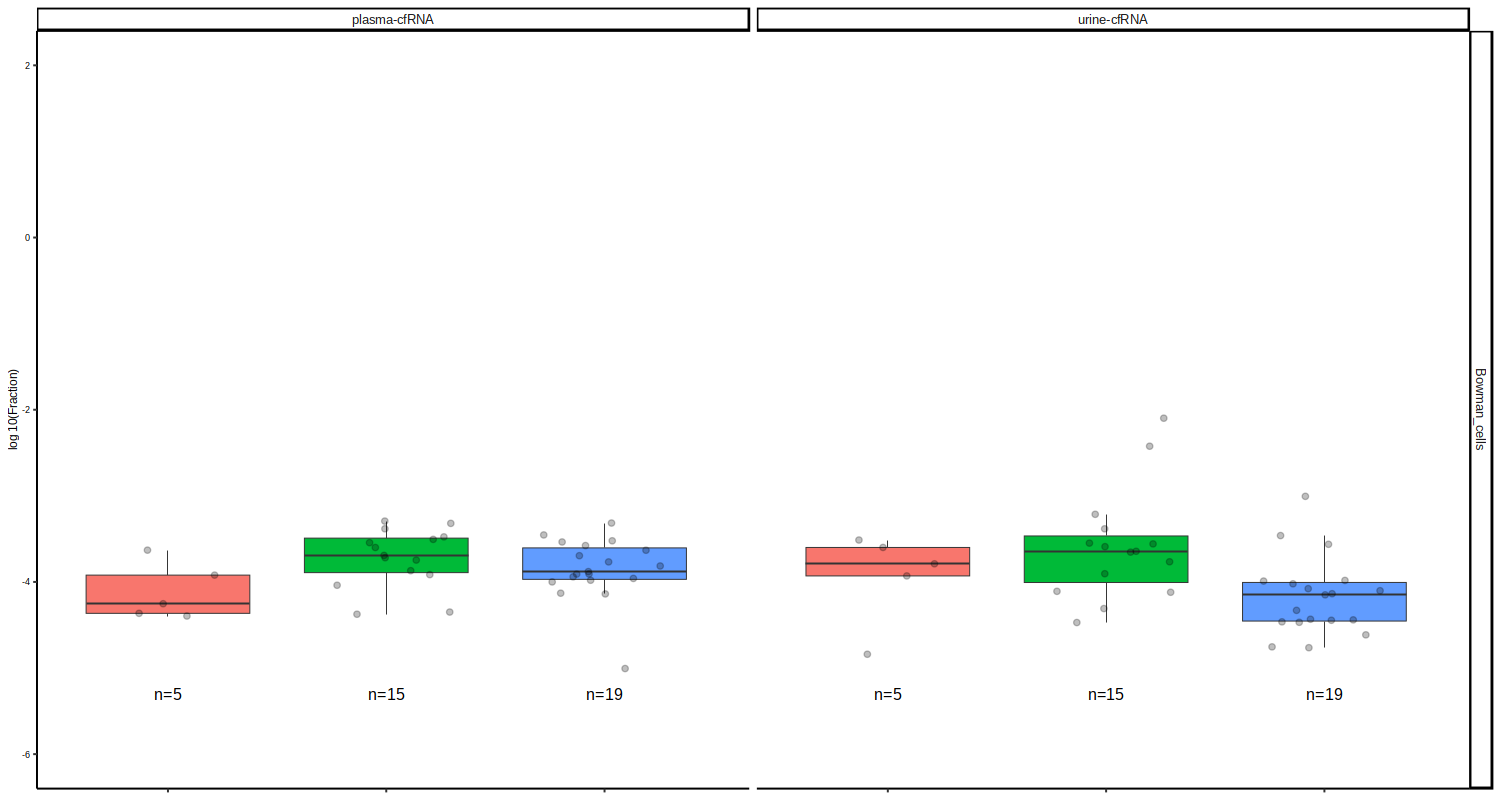

In [881]:
tubule =c(collecting_duct,loop_of_henle,connecting_tube,distal_convolution,proximal_tubule)

tubule_df = df %>% filter(cell_type  %in%  tubule)  %>% group_by(biofluid,condition,timepoint,sample_id) %>% 
summarise(fraction=sum(fraction))
tubule_df$cell_type<-"Epithelial_Cells_of_Tubules"


kidney_glomerulus=c("parietal_epithelial_cell")
bowman_df = df %>% filter(cell_type  %in%  kidney_glomerulus)  %>% group_by(biofluid,condition,timepoint,sample_id) %>% 
summarise(fraction=sum(fraction))
bowman_df$cell_type<-"Bowman_cells"

cell_df = rbind(tubule_df,bowman_df)

cell_df$cell_type=factor(cell_df$cell_type, levels = c("Epithelial_Cells_of_Tubules","Bowman_cells"))
cell_df = rbind(bowman_df)
cell_df$condition=factor(cell_df$condition, levels = c("Healthy","AKI"))

cell_df %>% ggplot(.,aes(condition,log10(fraction), fill=condition)) +
geom_boxplot(size=0.25,outlier.shape = NA) +  geom_point(position = position_jitterdodge( jitter.width = 0.6,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.25)+
facet_grid(cell_type~biofluid) + theme_classic() + ylab("log 10(Fraction)")+ scale_y_continuous(breaks = c(-5,-4,-3,-2,-1))+
theme(
    axis.title.x = element_blank(),
    axis.text.x = element_text(size = 8,family = "Helvetica", color="black"),
    axis.title.y = element_text(size = 8,family = "Helvetica", color="black"),
    axis.text.y = element_text(size=6,family = "Helvetica", color="black"),
    #legend.position = c(0.8, 0.8),
    legend.position = "none",
    legend.text = element_text(size=6),
    legend.title = element_blank(),
    legend.box.background = element_rect(),
    #strip.text.y = element_blank(),
  )+scale_fill_manual(values=c("#B2182B", "#2166AC"))
# ggpubr::stat_compare_means(
# comparisons = list(c("Healthy", "AKI")),
# method="wilcox",
# p.adjust.method = "bonferroni",
# size = 2.5,
# method.args=list(exact=TRUE,paired=FALSE))
#+stat_n_text()+ylim(-5.5,0)+scale_y_continuous(breaks = c(-5,-4,-3,-2,-1))
ggsave("/workdir/omm35/paper_urine_cfrna/figures/figure_3/main_figure_3.pdf",height=5.5,width=8.5, units="cm")


cell_df %>% group_by(biofluid,condition,cell_type) %>% summarise(mean=mean(fraction),sdev=sd(fraction))


cell_df %>% ggplot(.,aes(timepoint,log10(fraction), fill=timepoint)) +
geom_boxplot(size=0.25,outlier.shape = NA) +  geom_point(position = position_jitterdodge( jitter.width = 0.6,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.25)+
facet_grid(cell_type~biofluid) + theme_classic()+stat_n_text() + ylab("log 10(Fraction)")+
theme(
    axis.title.x = element_blank(),
    axis.text.x = element_blank(),
    axis.title.y = element_text(size = 8,family = "Helvetica", color="black"),
    axis.text.y = element_text(size=6,family = "Helvetica", color="black"),
    #legend.position = c(0.8, 0.8),
    legend.position = "none",
    legend.text = element_text(size=6),
    legend.title = element_blank(),
    legend.box.background = element_rect(),
    #strip.text.y = element_blank(),
  )+ ylim(-6,2)
#ggsave("/workdir/omm35/paper_urine_cfrna/figures/figure_3/supplementary_figure_3.pdf",height=14,width=10, units="cm")

In [2]:
####for AKI causes
set.seed(9)
colorBlindBlack8  <- c("#000000", "#E69F00", "#56B4E9", "#009E73", 
                       "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
colorBlindBlack8  = sample(colorBlindBlack8)
tubule =c(collecting_duct,loop_of_henle,connecting_tube,distal_convolution,proximal_tubule)

tubule_df = df %>% filter(cell_type  %in%  tubule)  %>% group_by(biofluid,condition,timepoint,causes2,sample_id) %>% 
summarise(fraction=sum(fraction))
tubule_df$cell_type<-"Epithelial_Cells_of_Tubules"


kidney_glomerulus=c("parietal_epithelial_cell")
bowman_df = df %>% filter(cell_type  %in%  kidney_glomerulus)  %>% group_by(biofluid,condition,timepoint,causes2,sample_id) %>% 
summarise(fraction=sum(fraction))
bowman_df$cell_type<-"Bowman_cells"

cell_df = rbind(tubule_df,bowman_df)

cell_df$cell_type=factor(cell_df$cell_type, levels = c("Epithelial_Cells_of_Tubules","Bowman_cells"))

cell_df$condition=factor(cell_df$condition, levels = c("Healthy","AKI"))

cell_df$causes2=factor(cell_df$causes2, levels = c("Healthy","AIN","other"))

cell_df %>% ggplot(.,aes(timepoint,log10(fraction), fill=causes2)) +
geom_boxplot(size=0.25,outlier.shape = NA, position = position_dodge2(preserve = "single")) +  geom_point(position = position_jitterdodge( jitter.width = 0.1,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.25)+
facet_grid(cell_type~biofluid) + theme_classic()+stat_n_text() + ylab("log 10(Fraction)")+
theme(
    axis.title.x = element_text(size = 12,family = "Helvetica", color="black"),
    axis.text.x = element_text(size = 8,family = "Helvetica", color="black"),
    axis.title.y = element_text(size = 8,family = "Helvetica", color="black"),
    axis.text.y = element_text(size=6,family = "Helvetica", color="black"),
    #legend.position = c(0.8, 0.8),
    legend.position = "none",
    legend.text = element_text(size=6),
    legend.title = element_blank(),
    legend.box.background = element_rect(),
    strip.text.y = element_blank(),
  )+scale_fill_manual(values=c("#0072B2","orange","#009E73"))+
ggpubr::stat_compare_means(
comparisons = list(c("AIN","other")),
method="wilcox",
p.adjust.method = "bonferroni",
size = 2.5,
method.args=list(exact=TRUE,paired=FALSE))
                   
ggsave("/workdir/omm35/paper_urine_cfrna/figures/figure_3/supp_figure_3_AIN_vs_other.pdf",height=9,width=10, units="cm")

cell_df  %>% ggplot(.,aes(causes2,log10(fraction), fill=causes2)) +
geom_boxplot(size=0.25,outlier.shape = NA, position = position_dodge2(preserve = "single")) +  geom_point(position = position_jitterdodge( jitter.width = 0.1,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.25)+
facet_grid(cell_type~biofluid) + theme_classic()+stat_n_text() + ylab("log 10(Fraction)")+
theme(
    axis.title.x = element_text(size = 12,family = "Helvetica", color="black"),
    axis.text.x = element_text(size = 8,family = "Helvetica", color="black"),
    axis.title.y = element_text(size = 8,family = "Helvetica", color="black"),
    axis.text.y = element_text(size=6,family = "Helvetica", color="black"),
    #legend.position = c(0.8, 0.8),
    legend.position = "none",
    legend.text = element_text(size=6),
    legend.title = element_blank(),
    legend.box.background = element_rect(),
    #strip.text.y = element_blank(),
  )+scale_fill_manual(values=c("#0072B2","orange","#009E73"))+
ggpubr::stat_compare_means(
comparisons = list(c("AIN","Healthy"),c("other","Healthy"), c("AIN","other")),
method="wilcox",
p.adjust.method = "bonferroni",
size = 2.5,
method.args=list(exact=TRUE,paired=FALSE))
ggsave("/workdir/omm35/paper_urine_cfrna/figures/figure_3/supp_figure_3_AIN_vs_other_2.pdf",height=9,width=8, units="cm")

timepoint,sample_id,cell_type,fraction,biofluid,study_id,paired,causeAKI_verified,condition,causes,causes2
<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
T0,irb-u-cfrna-1-A,B_cell,0.0004807219,urine-cfRNA,NA,NA,Healthy,Healthy,Healthy,Healthy
T0,irb-u-cfrna-1-A,T_cell,0.0002437732,urine-cfRNA,NA,NA,Healthy,Healthy,Healthy,Healthy
T0,irb-u-cfrna-1-A,adventitial_cell,0.0001486189,urine-cfRNA,NA,NA,Healthy,Healthy,Healthy,Healthy
T0,irb-u-cfrna-1-A,basal_cell_of_prostate_epithelium,0.0003210432,urine-cfRNA,NA,NA,Healthy,Healthy,Healthy,Healthy
T0,irb-u-cfrna-1-A,basophil,0.0004026116,urine-cfRNA,NA,NA,Healthy,Healthy,Healthy,Healthy
T0,irb-u-cfrna-1-A,bladder_urothelial_cell,0.2453508719,urine-cfRNA,NA,NA,Healthy,Healthy,Healthy,Healthy


`summarise()` has grouped output by 'biofluid'. You can override using the `.groups` argument.


biofluid,timepoint,fraction
<fct>,<chr>,<dbl>
plasma-cfRNA,T0,0.003010379
plasma-cfRNA,TP1,0.041775315
plasma-cfRNA,TP2,0.041775448
urine-cfRNA,T0,0.604379843
urine-cfRNA,TP1,3.300932371
urine-cfRNA,TP2,4.628796566


`summarise()` has grouped output by 'biofluid', 'condition', 'causes', 'timepoint'. You can override using the `.groups` argument.


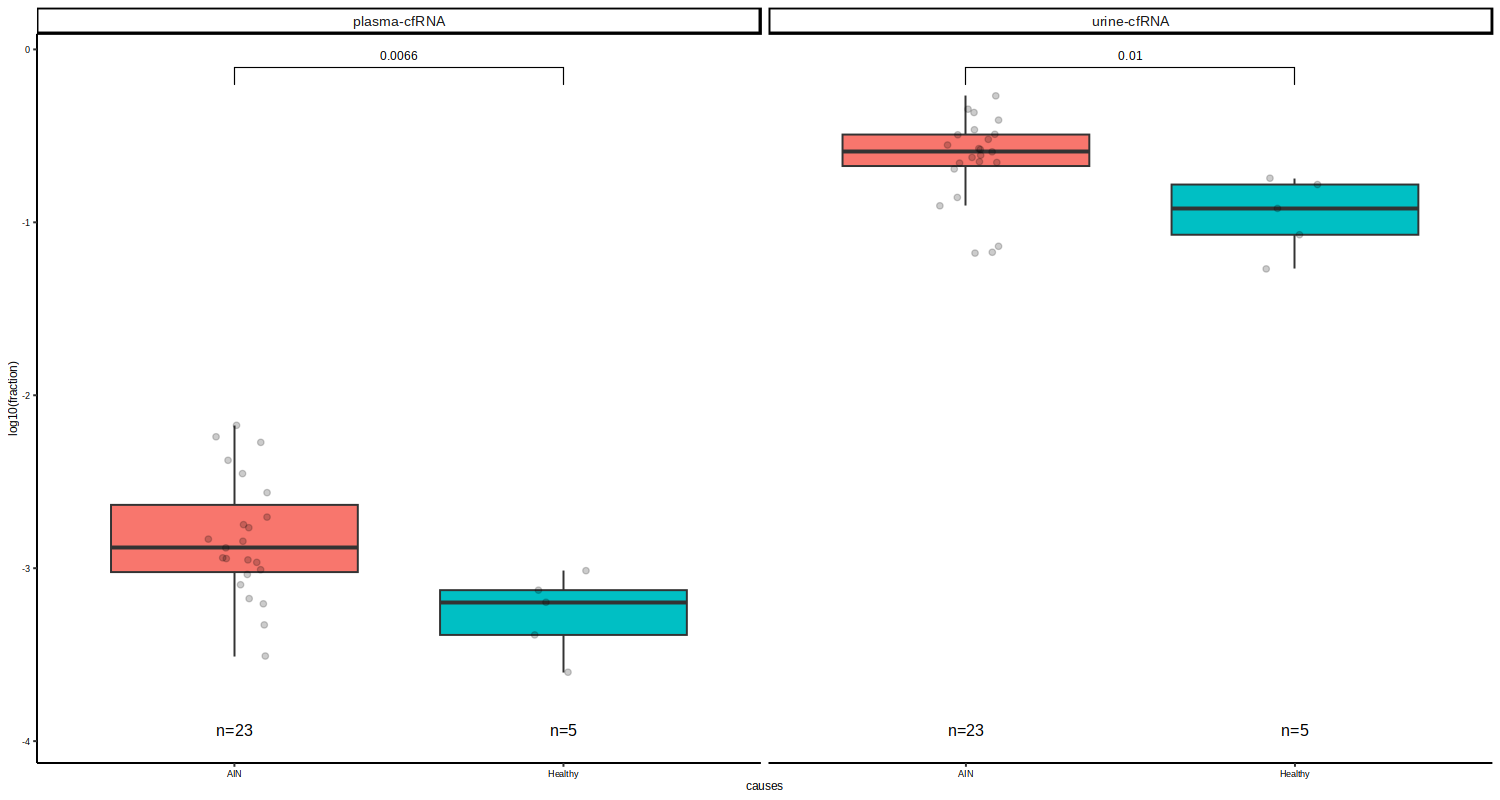

In [841]:
head(df)
cells_of_interest  = c(loop_of_henle,connecting_tube,proximal_tubule,distal_convolution,collecting_duct)
df %>% filter(cell_type %in% cells_of_interest) %>% group_by(biofluid,timepoint) %>% summarise(fraction=sum(fraction)) 








#df$condition=factor(df$condition,levels = c("Healthy","AKI"))
graph = df  %>% filter(causes=="AIN" |  causes=="Healthy") %>% filter(cell_type %in% cells_of_interest) %>% group_by(biofluid,condition,causes,timepoint,sample_id) %>% summarise(fraction=sum(fraction)) %>%  ggplot(.,aes(causes,log10(fraction), fill=causes)) + 
geom_boxplot(size=0.5, outlier.shape = NA)+ geom_point(position = position_jitterdodge( jitter.width = 0.2,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.2)+theme_classic()+
scale_y_continuous(breaks = c(-5,-4,-3,-2,-1,0,1))+ stat_n_text()+
 theme(
 plot.title=element_text(size=12),
 axis.title=element_text(size=8, color="black"),
 axis.text.y =element_text(size=6,color="black"),
 axis.text.x =element_text(size=6,color="black"),
 title=element_text(size=8, color="black"),
 strip.text=element_text(size=10),
 legend.position="none",
 #strip.text.y = element_blank()
 ) + facet_grid(.~biofluid)+stat_compare_means(comparisons = list(c("Healthy", "AIN")),
                        method = "wilcox.test",p.adjust="bonferroni",
                                              size=3)
# ggtitle("Tubular Cells")+ stat_compare_means(
#                         method = "wilcox.test",p.adjust="bonferroni",
#                                               size=3)+facet_grid(cell_type~biofluid)
print(graph)
#ggsave("tubular_cells_with_causes_of_AKI.png", height=9,width=30,units = "cm")

`summarise()` has grouped output by 'biofluid', 'condition', 'causeAKI_verified', 'timepoint'. You can override using the `.groups` argument.


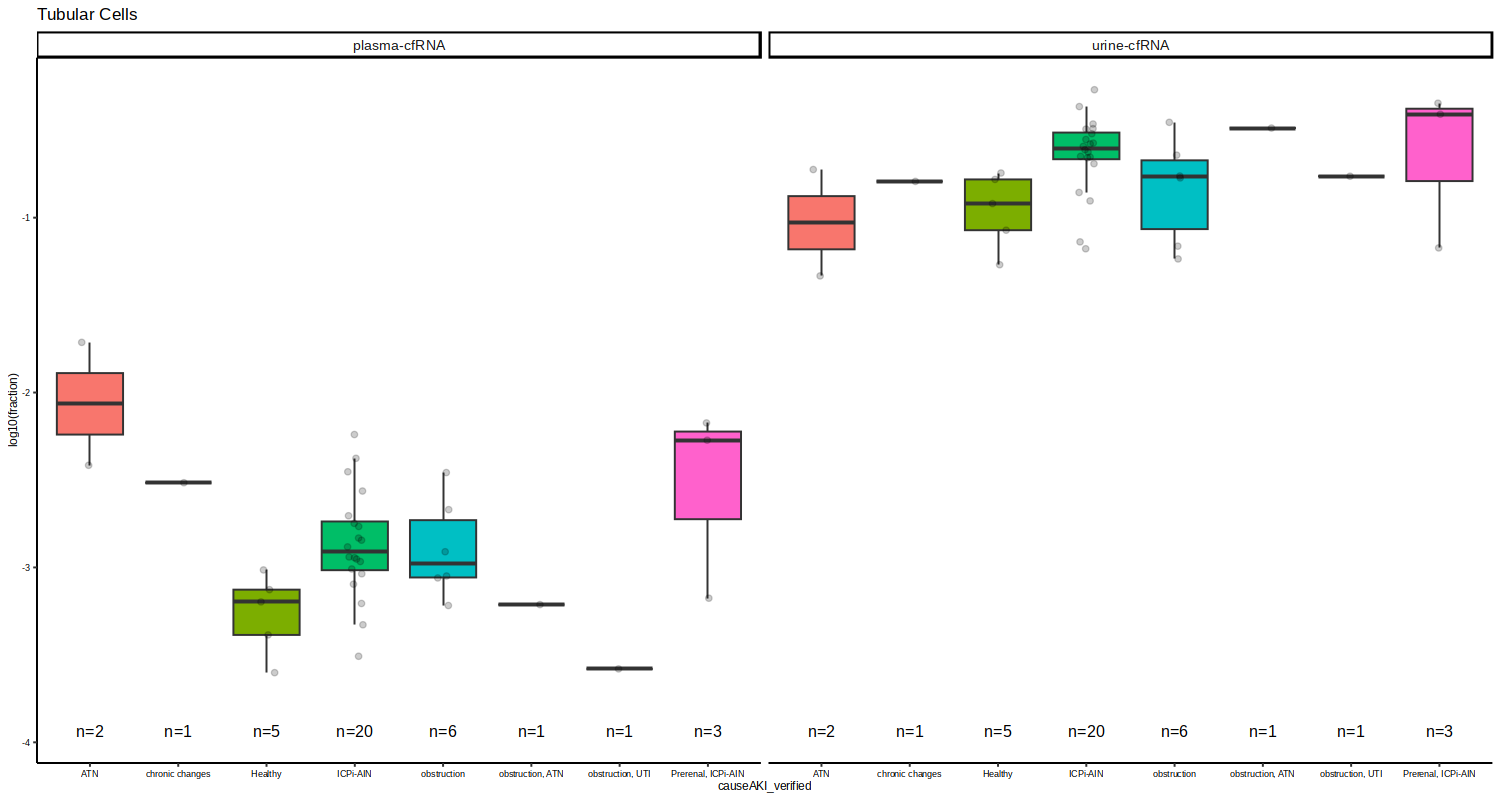

In [842]:

p = df %>% filter(cell_type %in% cells_of_interest) %>% group_by(biofluid,condition,causeAKI_verified,timepoint,sample_id) %>% summarise(fraction=sum(fraction))

ggplot(p,aes(causeAKI_verified,log10(fraction), fill=causeAKI_verified)) + 
geom_boxplot(size=0.5, outlier.shape = NA)+ geom_point(position = position_jitterdodge( jitter.width = 0.2,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.2)+theme_classic()+
scale_y_continuous(breaks = c(-5,-4,-3,-2,-1,0,1))+ stat_n_text()+
 theme(
 plot.title=element_text(size=12),
 axis.title=element_text(size=8, color="black"),
 axis.text.y =element_text(size=6,color="black"),
 axis.text.x =element_text(size=6,color="black"),
 title=element_text(size=8, color="black"),
 strip.text=element_text(size=10),
 legend.position="none",
 #strip.text.y = element_blank()
 ) + facet_grid(.~biofluid)+ ggtitle("Tubular Cells")

In [8]:
df_wide <- cor_df %>%
  pivot_wider(names_from = cell_type, values_from = fraction)

df_wide <- cor_df %>%
  pivot_wider(names_from = cell_type, values_from = fraction)df_wide$bladder_urothelial_cell = log10(df_wide$bladder_urothelial_cell)
df_wide

 # calculate stats

In [1]:
# stats_df = df %>% filter(cell_type %in% cells_of_interest)
# stats_df  %>% group_by(biofluid,timepoint,cell_type)  %>% summarise(mean=median(fraction), sdev=sd(fraction))

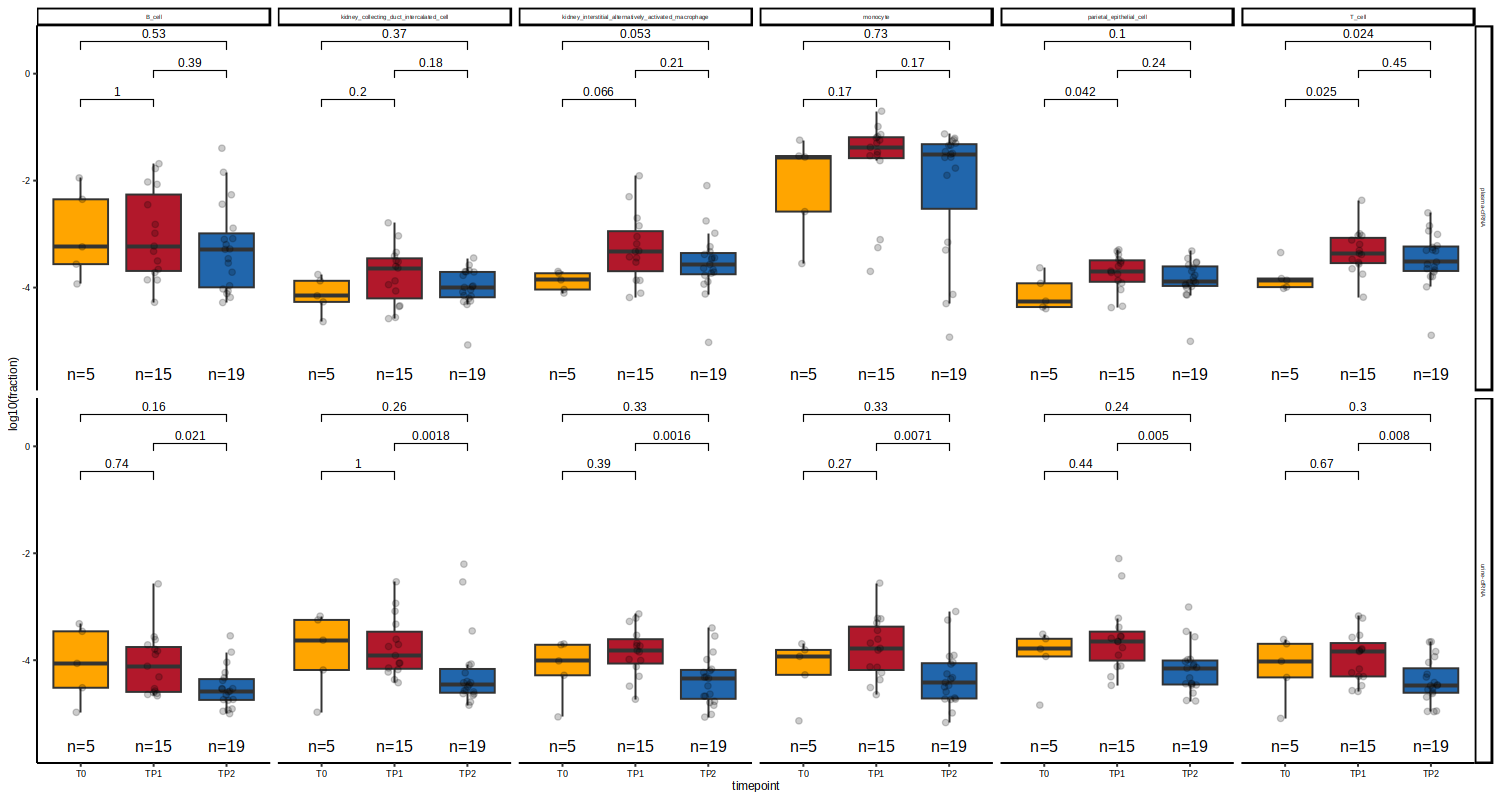

In [846]:
options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 100)
supp_cell_types = c("kidney_interstitial_alternatively_activated_macrophage","B_cell","T_cell","monocyte",
                    "kidney_collecting_duct_intercalated_cell",
                   "parietal_epithelial_cell"
                   )


loop_of_henle=c("kidney_loop_of_Henle_thick_ascending_limb_epithelial_cell",
               "kidney_loop_of_Henle_thin_ascending_limb_epithelial_cell",
               "kidney_loop_of_Henle_thin_descending_limb_epithelial_cell")



df %>% filter(cell_type %in% supp_cell_types) %>%  ggplot(.,aes(timepoint,log10(fraction), fill=timepoint)) + 
geom_boxplot(size=0.5, outlier.shape = NA)+ geom_point(position = position_jitterdodge( jitter.width = 0.2,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.2)+theme_classic()+stat_n_text()+ 
scale_fill_manual(values=c("orange","#B2182B", "#2166AC"))+
 theme(
 plot.title=element_text(size=8),
 axis.title=element_text(size=8, color="black"),
 axis.text.y =element_text(size=6,color="black"),
 axis.text.x =element_text(size=6,color="black"),
 title=element_text(size=8, color="black"),
 strip.text=element_text(size=4),
 legend.position="none") + stat_compare_means(comparisons = list(c("T0", "TP1"), c("TP2", "TP1"), c("T0", "TP2")),
                                              method = "wilcox.test", size=3)+facet_grid(biofluid~cell_type)

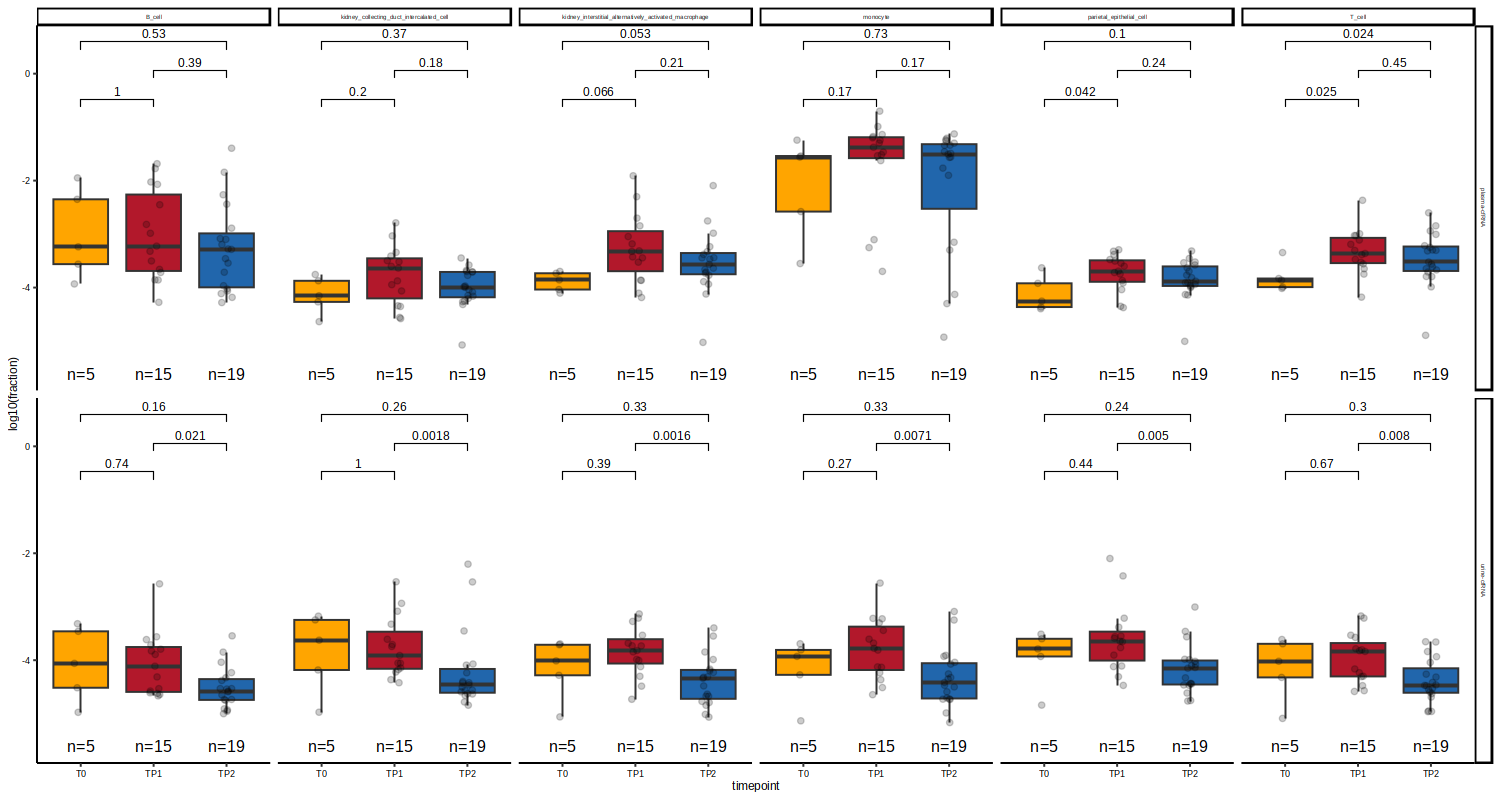

In [847]:
options(repr.plot.width = 15, repr.plot.height = 8, repr.plot.res = 100)
supp_cell_types = c("kidney_interstitial_alternatively_activated_macrophage","B_cell","T_cell","monocyte",
                    "kidney_collecting_duct_intercalated_cell",
                   "parietal_epithelial_cell"
                   )


loop_of_henle=c("kidney_loop_of_Henle_thick_ascending_limb_epithelial_cell",
               "kidney_loop_of_Henle_thin_ascending_limb_epithelial_cell",
               "kidney_loop_of_Henle_thin_descending_limb_epithelial_cell")



df %>% filter(cell_type %in% supp_cell_types) %>%  ggplot(.,aes(timepoint,log10(fraction), fill=timepoint)) + 
geom_boxplot(size=0.5, outlier.shape = NA)+ geom_point(position = position_jitterdodge( jitter.width = 0.2,
  jitter.height = 0,
  dodge.width = 0.75,
  seed = NA), alpha=0.2)+theme_classic()+stat_n_text()+ 
scale_fill_manual(values=c("orange","#B2182B", "#2166AC"))+
 theme(
 plot.title=element_text(size=8),
 axis.title=element_text(size=8, color="black"),
 axis.text.y =element_text(size=6,color="black"),
 axis.text.x =element_text(size=6,color="black"),
 title=element_text(size=8, color="black"),
 strip.text=element_text(size=4),
 legend.position="none") + stat_compare_means(comparisons = list(c("T0", "TP1"), c("TP2", "TP1"), c("T0", "TP2")),
                                              method = "wilcox.test", size=3)+facet_grid(biofluid~cell_type)
#scale_y_continuous(breaks = c(-6,-5,-4,-3,-2,-1,0,1))
#ggsave("/workdir/omm35/paper_urine_cfrna/figures/figure_3/supp_AKI_significant_cell_types_1000.pdf", height=9 , width=17.5, units = "cm")

In [849]:
new_df = df %>% filter(cell_type %in% cells_of_interest) %>% group_by(biofluid,timepoint,cell_type) %>% summarise(median=median(fraction))
# head(new_df)

`summarise()` has grouped output by 'biofluid', 'timepoint'. You can override using the `.groups` argument.


biofluid,timepoint,cell_type,median
<fct>,<chr>,<chr>,<dbl>
plasma-cfRNA,T0,epithelial_cell_of_proximal_tubule,7.148524e-05
plasma-cfRNA,T0,kidney_collecting_duct_intercalated_cell,7.031179e-05
plasma-cfRNA,T0,kidney_collecting_duct_principal_cell,7.529681e-05
plasma-cfRNA,T0,kidney_connecting_tubule_epithelial_cell,7.422641e-05
plasma-cfRNA,T0,kidney_distal_convoluted_tubule_epithelial_cell,6.406511e-05
plasma-cfRNA,T0,kidney_loop_of_Henle_thick_ascending_limb_epithelial_cell,6.238584e-05
